In [4]:
import pandas as pd
from fun import *
from common import generate_mapper
from groq import Groq
from dotenv import load_dotenv
import os
import json

In [2]:
df = pd.read_csv("../data/translations.csv")
df.head()

,lp,src,mt,ref,score,raw,annotators,domain,year,l1,l2
0,en-zh,Police said in a statement at the time that th...,警方在当时的一份声明中表示，他们决定以“沉重的心情”结束对 Jacsun 的搜索，但指出他们...,警方在当时的一份声明中表示，他们在决定结束对杰森的搜寻时，是怀着“沉重的心情”的，并指出他们...,0.238989,80.500000,4,news,2020,en,zh
1,en-zh,"Trump will likely veto the resolution, the six...",特 朗 普 可 能 会 否 决 该 决 议 ， 这 是 他 第 六 次 以 总 统 身 份 ...,特朗普很可能行使总统否决权，这将是他成为总统以来第6次否决国会立法。他早在三月已动用否决权，...,0.487842,81.166667,6,news,2020,en,zh
2,en-zh,The man arrived at work about 9.30am after fai...,该名男子未能回复同事的几条短信和电话，于上午9.30左右上班。,该男子大约在上午 9:30 到达工作单位，在此之前，他未能回复同事发来的几条信息和打来的电话。,0.469850,80.500000,4,news,2020,en,zh
3,en-zh,Are hopes for a nuclear-free world realistic?,对一个无核世界的希望是现实的吗 ？,实现无核化世界的希望是否现实？,0.626218,81.000000,4,news,2020,en,zh
4,en-zh,The California attorney general's office in Ma...,"3月,加利福尼亚总检察长办公室在经过近一年的调查后拒绝提出州刑事指控,当时,总检察长Xavi...",3 月，加州总检察长办公室在完成了近一年的案件调查后，拒绝对两名警察提起加州刑事起诉。总检察...,-0.207602,59.000000,4,news,2020,en,zh


In [3]:
with open("../data/prompts/PROMPT4.txt", "r") as f:
    prompt_template = f.read()

print(prompt_template)

Please evaluate the quality of the translation from [ORIGINAL LANGUAGE] to [TRANSLATED LANGUAGE] based on accuracy, fluency, and coherence.
Provide a score from 0 to 100 to indicate the overall quality of the translation.



In [4]:
language_mapper = {
    "en": "English",
    "fi": "Finnish",
    "de": "German",
    "hi": "Hindi",
    "xh": "Xhosa",
    "zh": "Chinese",
    "cs": "Czech",
    "fr": "French",
    "bn": "Bengali",
    "zu": "Zulu",
}

In [5]:
df["l1"] = df["l1"].map(language_mapper)
df["l2"] = df["l2"].map(language_mapper)

In [6]:
def get_conversation_groq(
    src_language: str, trg_language: str, src_sentence: str, trg_sentence: str
) -> str:
    messages = [
        {
            "role": "system",
            "content": f"""Please evaluate the quality of the translation from {src_language} to {trg_language} based on accuracy, fluency, and coherence: \n Provide a score from 0 to 100 to indicate the overall quality of the translation. Provide only the score, nothing else.""",
        },
        {
            "role": "user",
            "content": f'Original sentence: "{src_sentence}" \n Translated sentence: "{trg_sentence}"',
        },
    ]
    return messages

In [7]:
df["message"] = df.apply(
    lambda x: get_conversation_groq(x["l1"], x["l2"], x["src"], x["mt"]), axis=1
)

In [8]:
load_dotenv()

True

In [9]:
client = Groq()

In [10]:
input_data = df["message"].to_list()

In [11]:
input_data[0]

[{'role': 'system',
  'content': 'Please evaluate the quality of the translation from English to Chinese based on accuracy, fluency, and coherence: \n Provide a score from 0 to 100 to indicate the overall quality of the translation. Provide only the score, nothing else.'},
 {'role': 'user',
  'content': 'Original sentence: "Police said in a statement at the time that they made the decision to end the search for Jacsun with a "heavy heart," but noted they couldn\'t pinpoint a location in the landfill "to a point that would make continuing the search reasonable."" \n Translated sentence: "警方在当时的一份声明中表示，他们决定以“沉重的心情”结束对 Jacsun 的搜索，但指出他们无法确定垃圾填埋场的位置，“以至于继续搜索是合理的”。"'}]

In [12]:
last_idx = 0
max_rows = 2401
outfile = f'../data/mixtral/{last_idx}_starting_row.json'

with open(outfile, 'w') as output_file:
    output_file.write('[')
    for i in range(last_idx, len(input_data[:max_rows])):
        try:
            sample = input_data[i]
            chat_completion = client.chat.completions.create(
                messages=input_data[i],
                model="mixtral-8x7b-32768",
                temperature=0.5,
                max_tokens=1024,
                top_p=1,
                stop=None,
                stream=False,
            )
            answer = chat_completion.choices[0].message.content

            output_sample = {'sentence': sample[-1]['content'],'score': answer, 'id': i}

            output_file.write(json.dumps(output_sample))

            if i != (max_rows - 1):
                output_file.write(',')
        except:
            print('next start by:')
            print(i + 1)
            break
    output_file.write(']')

next start by:
663


In [ ]:
with open(outfile) as file:
    content = json.load(file)

In [11]:
def recover_all_files(path: str):
    files_content = []

    for filename in os.listdir(path):
        with open(f"{path}/{filename}") as infile:
            file_content = json.load(infile)
            files_content += file_content
    return pd.DataFrame(files_content).sort_values(by="id").reset_index(drop=True)

In [10]:
def get_score(response: str):
    pattern = r"\d+(?:\.\d+)?"
    
    match = re.search(pattern, response)
    score = float(match.group(0)) if match else None

    return score

In [12]:
df_mixtral = recover_all_files("../data/mixtral/")
df_mixtral

,sentence,score,id
0,"Original sentence: ""Police said in a statement...","Score: 95/100\n\nThe translation is accurate, ...",0
1,"Original sentence: ""Trump will likely veto the...","Score: 95\n\nThe translation is accurate, flue...",1
2,"Original sentence: ""The man arrived at work ab...","Score: 95\n\nThe translation is accurate, flue...",2
3,"Original sentence: ""Are hopes for a nuclear-fr...",Score: 95\n\nThe translation is accurate and c...,3
4,"Original sentence: ""The California attorney ge...","Score: 95/100\n\nThe translation is accurate, ...",4
...,...,...,...
2395,"Original sentence: ""Wayalela amagosa ukuba aye...",60/100\n\nThe translation is somewhat accurate...,2395
2396,"Original sentence: ""Ulimo lokuphila lulula, ol...",85/100\n\nThe translation is mostly accurate a...,2396
2397,"Original sentence: ""UMlawuli wezoTshutshiso lo...",85/100\n\nThe translation is generally accurat...,2397
2398,"Original sentence: ""Ukuphumla phezu kweentaba ...",85/100\n\nThe translation is generally accurat...,2398


In [21]:
df_mixtral["mixtral_score"] = df_mixtral["score"].map(get_score)
df_mixtral

,sentence,score,id,score_value,mixtral_score
0,"Original sentence: ""Police said in a statement...","Score: 95/100\n\nThe translation is accurate, ...",0,95.0,95.0
1,"Original sentence: ""Trump will likely veto the...","Score: 95\n\nThe translation is accurate, flue...",1,95.0,95.0
2,"Original sentence: ""The man arrived at work ab...","Score: 95\n\nThe translation is accurate, flue...",2,95.0,95.0
3,"Original sentence: ""Are hopes for a nuclear-fr...",Score: 95\n\nThe translation is accurate and c...,3,95.0,95.0
4,"Original sentence: ""The California attorney ge...","Score: 95/100\n\nThe translation is accurate, ...",4,95.0,95.0
...,...,...,...,...,...
2395,"Original sentence: ""Wayalela amagosa ukuba aye...",60/100\n\nThe translation is somewhat accurate...,2395,60.0,60.0
2396,"Original sentence: ""Ulimo lokuphila lulula, ol...",85/100\n\nThe translation is mostly accurate a...,2396,85.0,85.0
2397,"Original sentence: ""UMlawuli wezoTshutshiso lo...",85/100\n\nThe translation is generally accurat...,2397,85.0,85.0
2398,"Original sentence: ""Ukuphumla phezu kweentaba ...",85/100\n\nThe translation is generally accurat...,2398,85.0,85.0


In [25]:
df = pd.read_csv("../data/translations.csv")
df.head()

,lp,src,mt,ref,score,raw,annotators,domain,year,l1,l2
0,en-zh,Police said in a statement at the time that th...,警方在当时的一份声明中表示，他们决定以“沉重的心情”结束对 Jacsun 的搜索，但指出他们...,警方在当时的一份声明中表示，他们在决定结束对杰森的搜寻时，是怀着“沉重的心情”的，并指出他们...,0.238989,80.500000,4,news,2020,en,zh
1,en-zh,"Trump will likely veto the resolution, the six...",特 朗 普 可 能 会 否 决 该 决 议 ， 这 是 他 第 六 次 以 总 统 身 份 ...,特朗普很可能行使总统否决权，这将是他成为总统以来第6次否决国会立法。他早在三月已动用否决权，...,0.487842,81.166667,6,news,2020,en,zh
2,en-zh,The man arrived at work about 9.30am after fai...,该名男子未能回复同事的几条短信和电话，于上午9.30左右上班。,该男子大约在上午 9:30 到达工作单位，在此之前，他未能回复同事发来的几条信息和打来的电话。,0.469850,80.500000,4,news,2020,en,zh
3,en-zh,Are hopes for a nuclear-free world realistic?,对一个无核世界的希望是现实的吗 ？,实现无核化世界的希望是否现实？,0.626218,81.000000,4,news,2020,en,zh
4,en-zh,The California attorney general's office in Ma...,"3月,加利福尼亚总检察长办公室在经过近一年的调查后拒绝提出州刑事指控,当时,总检察长Xavi...",3 月，加州总检察长办公室在完成了近一年的案件调查后，拒绝对两名警察提起加州刑事起诉。总检察...,-0.207602,59.000000,4,news,2020,en,zh


In [26]:
results = df.join(df_mixtral, rsuffix="_")
results.head()

,lp,src,mt,ref,score,raw,annotators,domain,year,l1,l2,sentence,score_,id,score_value,mixtral_score
0,en-zh,Police said in a statement at the time that th...,警方在当时的一份声明中表示，他们决定以“沉重的心情”结束对 Jacsun 的搜索，但指出他们...,警方在当时的一份声明中表示，他们在决定结束对杰森的搜寻时，是怀着“沉重的心情”的，并指出他们...,0.238989,80.500000,4,news,2020,en,zh,"Original sentence: ""Police said in a statement...","Score: 95/100\n\nThe translation is accurate, ...",0,95.0,95.0
1,en-zh,"Trump will likely veto the resolution, the six...",特 朗 普 可 能 会 否 决 该 决 议 ， 这 是 他 第 六 次 以 总 统 身 份 ...,特朗普很可能行使总统否决权，这将是他成为总统以来第6次否决国会立法。他早在三月已动用否决权，...,0.487842,81.166667,6,news,2020,en,zh,"Original sentence: ""Trump will likely veto the...","Score: 95\n\nThe translation is accurate, flue...",1,95.0,95.0
2,en-zh,The man arrived at work about 9.30am after fai...,该名男子未能回复同事的几条短信和电话，于上午9.30左右上班。,该男子大约在上午 9:30 到达工作单位，在此之前，他未能回复同事发来的几条信息和打来的电话。,0.469850,80.500000,4,news,2020,en,zh,"Original sentence: ""The man arrived at work ab...","Score: 95\n\nThe translation is accurate, flue...",2,95.0,95.0
3,en-zh,Are hopes for a nuclear-free world realistic?,对一个无核世界的希望是现实的吗 ？,实现无核化世界的希望是否现实？,0.626218,81.000000,4,news,2020,en,zh,"Original sentence: ""Are hopes for a nuclear-fr...",Score: 95\n\nThe translation is accurate and c...,3,95.0,95.0
4,en-zh,The California attorney general's office in Ma...,"3月,加利福尼亚总检察长办公室在经过近一年的调查后拒绝提出州刑事指控,当时,总检察长Xavi...",3 月，加州总检察长办公室在完成了近一年的案件调查后，拒绝对两名警察提起加州刑事起诉。总检察...,-0.207602,59.000000,4,news,2020,en,zh,"Original sentence: ""The California attorney ge...","Score: 95/100\n\nThe translation is accurate, ...",4,95.0,95.0


In [33]:
results = results[results["mixtral_score"]<=100]
results

,lp,src,mt,ref,score,raw,annotators,domain,year,l1,l2,sentence,score_,id,score_value,mixtral_score
0,en-zh,Police said in a statement at the time that th...,警方在当时的一份声明中表示，他们决定以“沉重的心情”结束对 Jacsun 的搜索，但指出他们...,警方在当时的一份声明中表示，他们在决定结束对杰森的搜寻时，是怀着“沉重的心情”的，并指出他们...,0.238989,80.500000,4,news,2020,en,zh,"Original sentence: ""Police said in a statement...","Score: 95/100\n\nThe translation is accurate, ...",0,95.0,95.0
1,en-zh,"Trump will likely veto the resolution, the six...",特 朗 普 可 能 会 否 决 该 决 议 ， 这 是 他 第 六 次 以 总 统 身 份 ...,特朗普很可能行使总统否决权，这将是他成为总统以来第6次否决国会立法。他早在三月已动用否决权，...,0.487842,81.166667,6,news,2020,en,zh,"Original sentence: ""Trump will likely veto the...","Score: 95\n\nThe translation is accurate, flue...",1,95.0,95.0
2,en-zh,The man arrived at work about 9.30am after fai...,该名男子未能回复同事的几条短信和电话，于上午9.30左右上班。,该男子大约在上午 9:30 到达工作单位，在此之前，他未能回复同事发来的几条信息和打来的电话。,0.469850,80.500000,4,news,2020,en,zh,"Original sentence: ""The man arrived at work ab...","Score: 95\n\nThe translation is accurate, flue...",2,95.0,95.0
3,en-zh,Are hopes for a nuclear-free world realistic?,对一个无核世界的希望是现实的吗 ？,实现无核化世界的希望是否现实？,0.626218,81.000000,4,news,2020,en,zh,"Original sentence: ""Are hopes for a nuclear-fr...",Score: 95\n\nThe translation is accurate and c...,3,95.0,95.0
4,en-zh,The California attorney general's office in Ma...,"3月,加利福尼亚总检察长办公室在经过近一年的调查后拒绝提出州刑事指控,当时,总检察长Xavi...",3 月，加州总检察长办公室在完成了近一年的案件调查后，拒绝对两名警察提起加州刑事起诉。总检察...,-0.207602,59.000000,4,news,2020,en,zh,"Original sentence: ""The California attorney ge...","Score: 95/100\n\nThe translation is accurate, ...",4,95.0,95.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,xh-zu,Wayalela amagosa ukuba aye kwimoto yakhe eyi-O...,Wayala izikhulu zakhe ukuba ziye emotweni elan...,Uqondise izikhulu kuyi-Oldsmobile Intrigue yak...,0.636882,100.000000,1,wiki,2021,xh,zu,"Original sentence: ""Wayalela amagosa ukuba aye...",60/100\n\nThe translation is somewhat accurate...,2395,60.0,60.0
2396,xh-zu,"Ulimo lokuphila lulula, oludla ngokusebenzisa ...","Ukulima kokuphila kulula, imvamisa usebenzisa ...","Ukulimela ukuziphilisa indlela elula, ngovamil...",0.351844,90.000000,1,wiki,2021,xh,zu,"Original sentence: ""Ulimo lokuphila lulula, ol...",85/100\n\nThe translation is mostly accurate a...,2396,85.0,85.0
2397,xh-zu,"UMlawuli wezoTshutshiso loLuntu, u-Kier Starme...","UMqondisi Wezokushushiswa Komphakathi, uKier S...","UMqondisi wezoKubekwa Kwamacala koMphakathi, u...",0.636882,100.000000,1,wiki,2021,xh,zu,"Original sentence: ""UMlawuli wezoTshutshiso lo...",85/100\n\nThe translation is generally accurat...,2397,85.0,85.0
2398,xh-zu,"Ukuphumla phezu kweentaba ezisemantla e Mecca,...","Ukuphumula ezintabeni ezisenyakatho yeMecca, l...",Umhume ohlezi phezu kwenye yezintaba zasenyaka...,0.371967,50.000000,1,wiki,2021,xh,zu,"Original sentence: ""Ukuphumla phezu kweentaba ...",85/100\n\nThe translation is generally accurat...,2398,85.0,85.0


In [34]:
results[["lp", "raw", "mixtral_score"]]

,lp,raw,mixtral_score
0,en-zh,80.500000,95.0
1,en-zh,81.166667,95.0
2,en-zh,80.500000,95.0
3,en-zh,81.000000,95.0
4,en-zh,59.000000,95.0
...,...,...,...
2395,xh-zu,100.000000,60.0
2396,xh-zu,90.000000,85.0
2397,xh-zu,100.000000,85.0
2398,xh-zu,50.000000,85.0


In [35]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

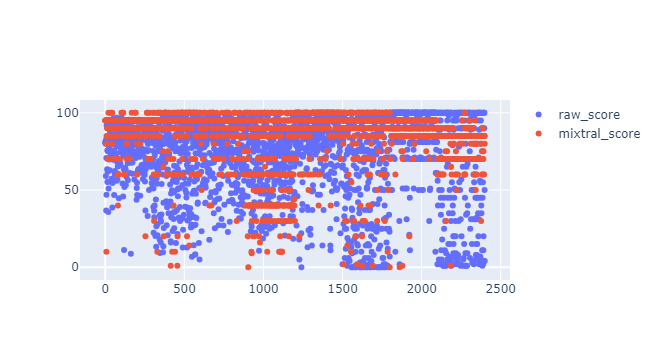

In [36]:
fig = make_subplots(rows=1, cols=1)

fig.add_trace(
    go.Scatter(x=results.index, y=results.raw, mode="markers", name="raw_score"), row=1, col=1
)

fig.add_trace(
    go.Scatter(x=results.index, y=results.mixtral_score, mode="markers", name="mixtral_score"),
    row=1,
    col=1,
)

fig.show()

In [37]:
def compute_correlation(
    df: pd.DataFrame,
    ground_truth: str = "raw",
    predicted: str = "gemma_score",
    method: str = "pearson",
    decimals=3,
):
    correlations = {
        "overall": round(df[ground_truth].corr(df[predicted], method=method), decimals)
    }

    for language_pair in df["lp"].unique():
        sub_df = df[df.lp == language_pair]
        correlations[language_pair] = round(
            sub_df[ground_truth].corr(sub_df[predicted], method=method), decimals
        )

    return correlations

In [40]:
for lan_par, score in compute_correlation(results, "raw", "mixtral_score").items():
    print(lan_par, score)

overall 0.352
en-zh 0.37
en-cs 0.435
en-de 0.512
fi-en 0.451
de-fr 0.322
de-cs 0.337
hi-bn 0.411
xh-zu 0.325


In [46]:
for lan_par, score in compute_correlation(results, "raw", "mixtral_score").items():
    print(f"& {score}")

& 0.352
& 0.37
& 0.435
& 0.512
& 0.451
& 0.322
& 0.337
& 0.411
& 0.325
